/tmp/ipykernel_55042/4064143071.py:13: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)


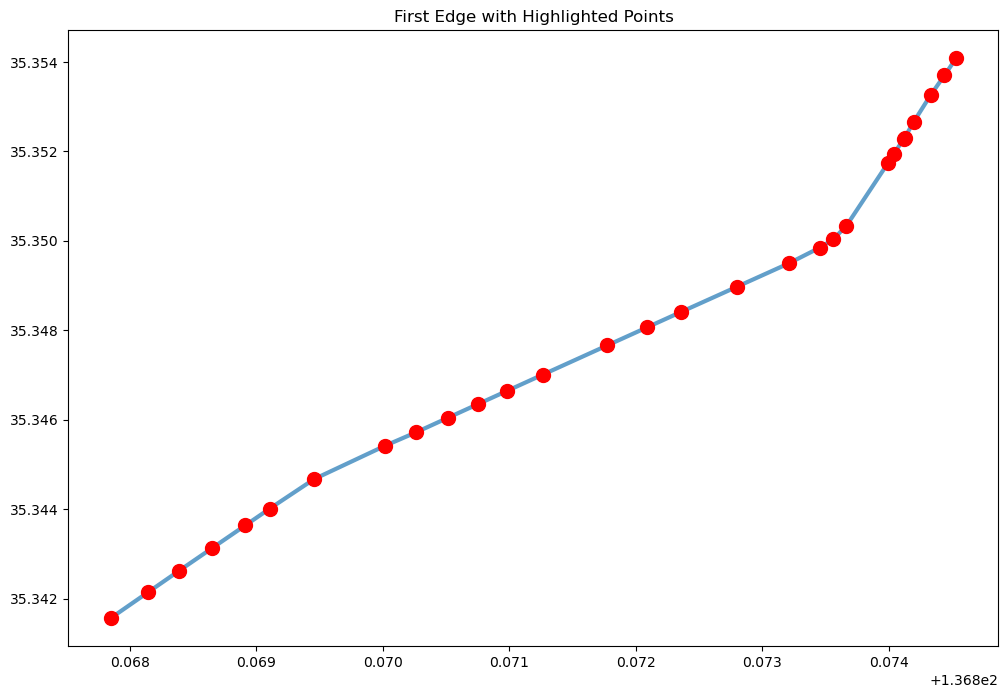

In [2]:

import osmnx as ox
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math

# 自宅周辺の軽いデータ
latitude_start = 35.336452
longitude_start = 136.922696
latitude_end = 35.297945
longitude_end = 136.971245
# キャッシュを使う
ox.config(use_cache=True, log_console=True)

graph = ox.graph_from_point(center_point=(latitude_start,longitude_start),
                            network_type='drive',
                           simplify=True,
                           retain_all=True,
                           dist=5000,
                           custom_filter='["highway"~"secondary|secondary_link|primary|primary_link|trunk|trunk_link"]["lanes"=2]')
graph2 = ox.graph_from_point(center_point=(latitude_start,longitude_start),
                            network_type='drive',
                           simplify=True,
                           retain_all=True,
                           dist=5000,
                           custom_filter='["highway"~"tertiary"]')
graph = nx.compose(graph, graph2)

gdf_edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)
gdf_nodes = ox.graph_to_gdfs(graph, nodes=True, edges=False)

gdf_edges["is_target"] = np.where(
    (gdf_edges["length"] >= 800),
    1,
    0,
)
gdf_edges = gdf_edges[gdf_edges["is_target"] == 1]

# 逆方向の道を削除する
drop_target = []
for index, row in gdf_edges.iterrows():
    # drop_indexにindex[1], index[0]が存在する場合はなにもしない
    if (index[1], index[0], 0) in drop_target:
        continue
    if (index[0], index[1], 0) in drop_target:
        continue
    drop_target.append(index)
gdf_edges = gdf_edges[gdf_edges.index.isin(drop_target)]

# def calculate_angle_between_vectors(A, B, C):
#     vector_AB = np.array(B) - np.array(A)
#     vector_BC = np.array(C) - np.array(B)
    
#     dot_product = np.dot(vector_AB, vector_BC)
#     norm_AB = np.linalg.norm(vector_AB)
#     norm_BC = np.linalg.norm(vector_BC)
    
#     cosine_theta = dot_product / (norm_AB * norm_BC)
#     angle_rad = np.arccos(cosine_theta)
#     angle_deg = np.degrees(angle_rad)
#     return angle_deg

# # 座標間の角度の変化の合計値を求める
# gdf_edges['geometory_angle_total'] = gdf_edges['geometry'].apply(
#     lambda x: sum([calculate_angle_between_vectors(x.coords[i-1], x.coords[i], x.coords[i+1]) for i in range(1, len(x.coords)-1)])
# )

# # 合計角度と距離の比率を求める
# gdf_edges['geometory_angle_rate'] = gdf_edges['geometory_angle_total'] / gdf_edges['length']

# # エッジ内のノード数を求める
# graph_all = ox.graph_from_point(center_point=(latitude_start,longitude_start),
#                             network_type='drive',
#                            simplify=True,
#                            retain_all=True,
#                            dist=5000)
# all_nodes = ox.graph_to_gdfs(graph_all, nodes=True, edges=False)
# gdf_edges['node_cnt'] = 0
# for index, row in gdf_edges.iterrows():
#   # ジオメトリーの座標と一致するノードを取得する
#   nodes = all_nodes[all_nodes.geometry.intersects(row.geometry)]
#   # 進行方向と逆方向のノードを除外して分岐数を計算する
#   gdf_edges.at[index, 'node_cnt'] = nodes['street_count'].sum() - (len(nodes) * 2)

# # 評価する
# gdf_edges['score'] = (1 - gdf_edges['geometory_angle_rate']) * (1 - (gdf_edges['node_cnt'] / gdf_edges['length']))
# gdf_edges['score_normalized'] = gdf_edges['score'] / gdf_edges['score'].max()
# # score_normalizedを並び替え
# gdf_edges = gdf_edges.sort_values('score_normalized', ascending=False)

# # score_normalizedの上位5件を表示する
# target_edges = gdf_edges.head(5)
# # target_edges = gdf_edges
# graph = ox.graph_from_gdfs(gdf_nodes, target_edges)

# 先頭のエッジを取得
first_edge = gdf_edges.iloc[0]

# 先頭のエッジのジオメトリを取得
geometry = first_edge.geometry

# グラフを描画
fig, ax = plt.subplots(figsize=(12, 8))

# エッジを描画
x, y = geometry.xy
ax.plot(x, y, alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

# エッジ上の点を強調
ax.scatter(x, y, color='red', s=100, zorder=3)

# グラフのタイトルと軸を設定
ax.set_title('First Edge with Highlighted Points')
plt.show()
